In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from datetime import date
from flask import Flask, request, jsonify
import pickle
import joblib
from sklearn.multioutput import MultiOutputRegressor

In [2]:
df = pd.read_csv("dataset_S1_S2.csv")


In [3]:
df = df.fillna(df.median(numeric_only = True))

-0.12208451279581298


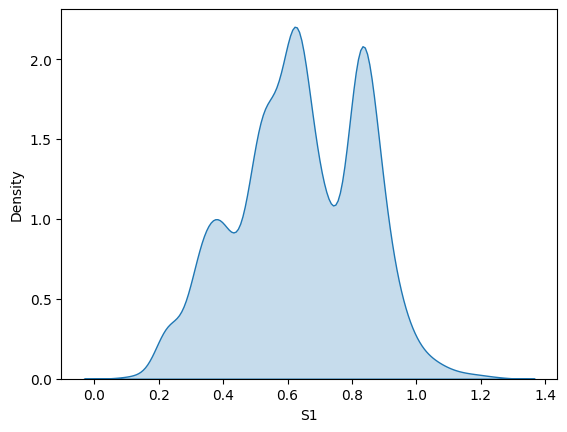

In [4]:
sns.kdeplot(df['S1'],fill=True)
print(df['S1'].skew())

-0.07771540747835176


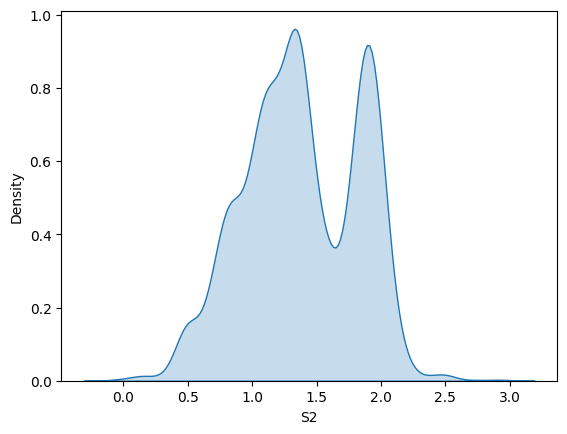

In [5]:
sns.kdeplot(df['S2'],fill=True)
print(df['S2'].skew())

-0.3130412344993311


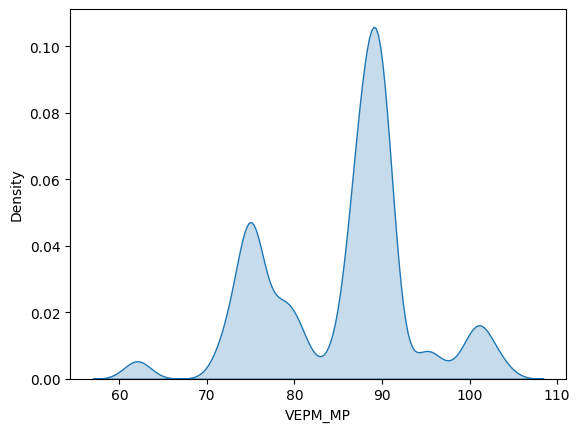

In [6]:
sns.kdeplot(df['VEPM_MP'],fill=True)
print(df['VEPM_MP'].skew())

-0.053214635181816024


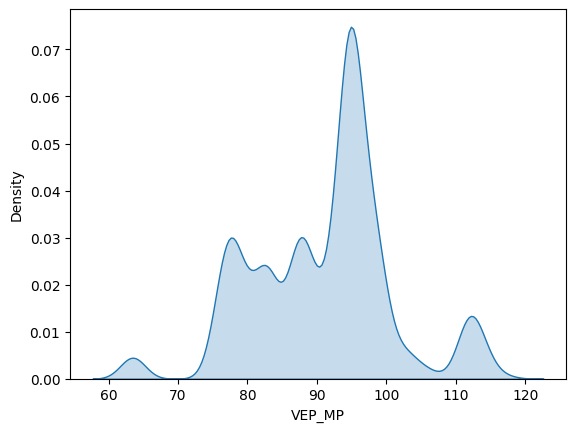

In [7]:
sns.kdeplot(df['VEP_MP'],fill=True)
print(df['VEP_MP'].skew())

0.08822643033564824


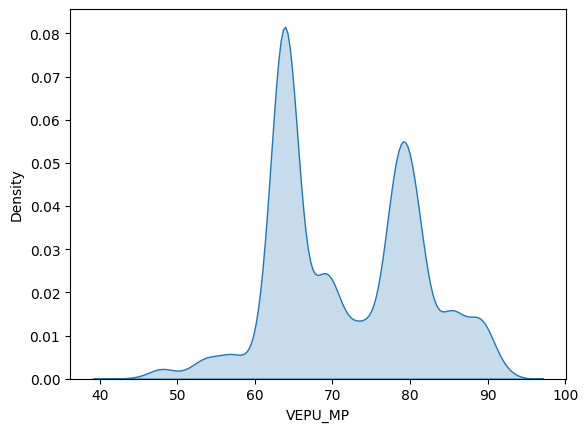

In [8]:
sns.kdeplot(df['VEPU_MP'],fill=True)
print(df['VEPU_MP'].skew())

## Outlier deletion

In [9]:
selected_features = ["S1","S2","VEPM_MP","VEPU_MP","VEP_MP","VEPM_TIME_TAKEN","VEPU_TIME_TAKEN","VEP_TIME_TAKEN"]
Q1 = df[selected_features].quantile(0.25)
Q3 = df[selected_features].quantile(0.75)
IQR = Q3 - Q1
df_filtered = df[~((df[selected_features] < (Q1 - 2.0 * IQR)) | 
                    (df[selected_features] > (Q3 + 2.0 * IQR))).any(axis=1)]
df = df_filtered


-0.12203439216819759


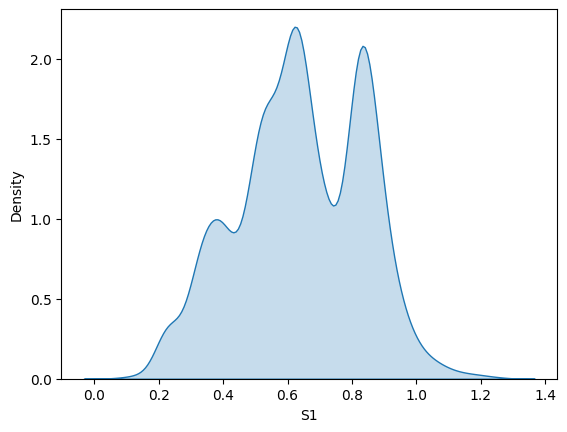

In [10]:
sns.kdeplot(df['S1'],fill=True)
print(df['S1'].skew())

-0.07805075500004117


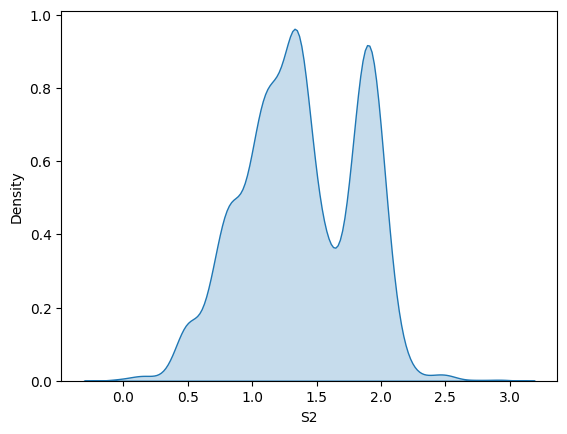

In [11]:
sns.kdeplot(df['S2'],fill=True)
print(df['S2'].skew())

-0.3147553059547264


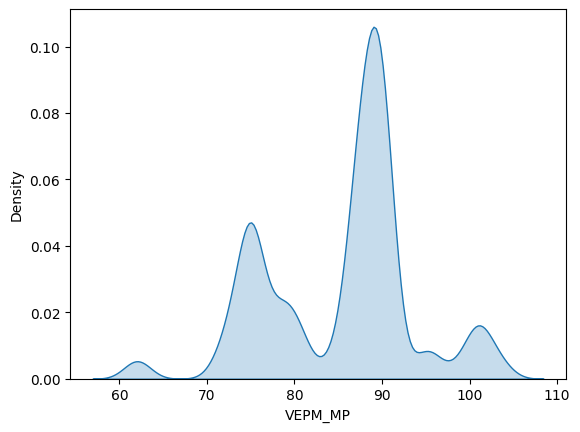

In [12]:
sns.kdeplot(df['VEPM_MP'],fill=True)
print(df['VEPM_MP'].skew())

-0.053695044667585436


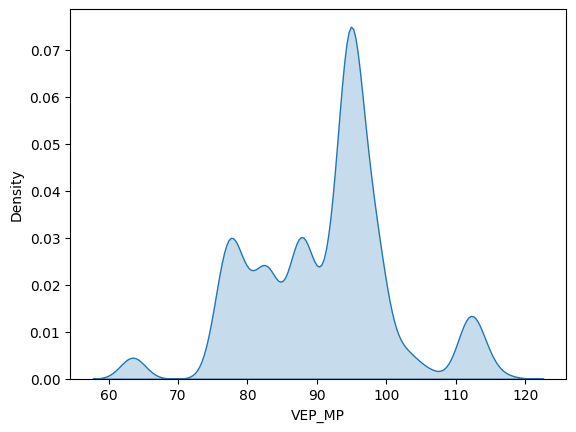

In [13]:
sns.kdeplot(df['VEP_MP'],fill=True)
print(df['VEP_MP'].skew())

0.08749208849169325


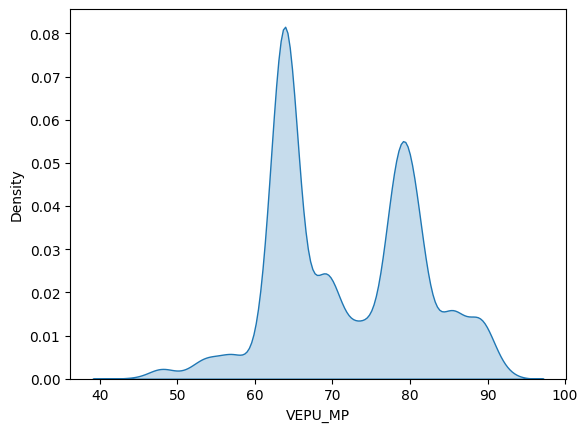

In [14]:
sns.kdeplot(df['VEPU_MP'],fill=True)
print(df['VEPU_MP'].skew())

In [15]:
X = df[["LDA_PARTNUMBER","VEPM_MP","VEPM_TIME_TAKEN","VEPU_MP","VEPU_TIME_TAKEN","VEP_MP","VEP_TIME_TAKEN"]]
y = df[["S1","S2"]] 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 142)
print(X_train.shape,X_test.shape)
y_train.shape,y_test.shape

(4447, 7) (1112, 7)


((4447, 2), (1112, 2))

## Random Forest and  XGBoost Model

In [18]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring="r2")

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {cv_scores.mean()*100:.2f}%")

rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {(mse_rf)*100:.2f}, R²: {(r2_rf)*100:.2f}%")

Cross-Validation R² Scores: [0.87345729 0.9012573  0.89750476 0.93191109 0.92085381]
Mean R² Score: 90.50%
Random Forest - MSE: 1.65, R²: 85.47%


In [19]:
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

xgb = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
xgb.fit(X_train_scaled, y_train)


cv_scores1 = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring="r2")

print(f"Cross-Validation R² Scores: {cv_scores1}")
print(f"Mean R² Score: {cv_scores1.mean()*100:.2f}%")

xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MSE: {(mse_xgb)*100:.2f}%, R²: {(r2_xgb)*100:.2f}%")

Cross-Validation R² Scores: [0.87345729 0.9012573  0.89750476 0.93191109 0.92085381]
Mean R² Score: 90.50%
XGBoost - MSE: 1.51%, R²: 86.77%


In [20]:
#              [LDA_partnumber,vepm,vepm_time,vepu,vepu_time,vep,vep_time]
manual_input = np.array([[5083, 66.99, 0, 57.04, 0, 71.73, 0]])

manual_scaled = scaler.fit_transform(manual_input)

predicted_manual = xgb.predict(manual_scaled)

predicted = np.array(predicted_manual)

prediction_table = {
    "date": date.today(),
    "LDA_PARTNUMBER": int(manual_input[0][0]),          
    "Predicted S1": predicted[0][0],
    "Predicted S2": predicted[0][1]
}

prediction_df = pd.DataFrame([prediction_table])

prediction_df


,date,LDA_PARTNUMBER,Predicted S1,Predicted S2
0,2025-07-16,5083,0.803353,1.702594


In [ ]:
# import joblib
# joblib.dump(xgb, "xgb_model.pkl")      # ✅ This will save the full multi-output model
# joblib.dump(scaler, "scaler.pkl")      # Also save your scaler


In [21]:
rf1 = joblib.load("xgb_model.pkl")
scaler = joblib.load("scaler.pkl")

test_input = [[5083, 66.99, 0, 57.04, 0, 71.73, 0]]
scaled_input = scaler.transform(test_input)

prediction = rf1.predict(scaled_input)
print("S1:", prediction[0][0],"S2:", prediction[0][1])


S1: 0.803353 S2: 1.7025939


In [22]:
fd = pd.read_csv("LDA_EPT_data.csv")

In [24]:
fd.isna().sum()

PH_PART_NUMBER               0
MP1_S1_Value                27
MP1_P1_Value                29
MP1_S1_Setting_Tolerance     1
MP2_S2_Value                27
MP2_P2_Value                17
MP2_S2_Setting_Tolerance     1
dtype: int64